In [72]:
from sklearn.linear_model import LogisticRegression 
import numpy as np

X_raw = np.loadtxt("all_matrix.tsv", delimiter='\t')

lr = LogisticRegression()

In [73]:
shuffle_ids = np.random.permutation(X_size)

In [82]:
from sklearn.preprocessing import normalize

X_size = X_raw.shape[0]

y = np.zeros((X_size, ), dtype=np.uint8)

for i in range(X_size/2):
    y[i] = 1

X = normalize(X_raw)
X = X[shuffle_ids]
y = y[shuffle_ids]

X_train = X[:X_size/2]
y_train = y[:X_size/2]

X_test = X[X_size/2:]
y_test = y[X_size/2:]

In [83]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [84]:
results = lr.predict(X_test)

In [90]:
diff = results - y_test
total = 0
false_p = 0
false_n = 0
for i in diff:
    if i == 255:
        false_n += 1
        total += 1
    if i == 1:
        false_p += 1
        total += i

print float(total)/(X_size/2)
print float(false_p)/(X_size/2)
print float(false_n)/(X_size/2)

0.143736716035
0.0630545528154
0.0806821632199


In [86]:
lr.score(X_test, y_test)

0.85626328396477847

In [87]:
lr.score(X_train, y_train)

0.85820316453560941

In [140]:
y_test.shape

(59282,)

In [136]:
import pandas as pd
coefs = lr.coef_
motif_list = pd.read_csv("human_pwm_ids_sorted.txt", sep=' ', header=None)
sort_ids = np.flip(np.argsort(coefs), 1)
motif_list['coeff'] = coefs.T
print motif_list.iloc[sort_ids[0][:50], [1,2,3]]

            1                   2      coeff
125  MA0139.1                CTCF  13.170876
480  MA1102.1               CTCFL   4.765981
197  MA0506.1                NRF1   4.756761
185  MA0490.1                JUNB   3.244621
112  MA0119.1          NFIC::TLX1   3.145975
421  MA0833.1                ATF4   2.996172
426  MA0838.1               CEBPG   2.983627
138  MA0153.2               HNF1B   2.886430
324  MA0732.1                EGR3   2.883915
519  MA1141.1           FOS::JUND   2.858019
52   MA0060.1                NFYA   2.675266
174  MA0476.1                 FOS   2.614362
402  MA0812.1       TFAP2B(var.2)   2.531983
18   MA0028.1                ELK1   2.503965
166  MA0470.1                E2F4   2.429829
513  MA1135.1          FOSB::JUNB   2.365799
134  MA0149.1          EWSR1-FLI1   2.251118
216  MA0527.1              ZBTB33   2.237993
1    MA0003.1              TFAP2A   2.225375
342  MA0751.1                ZIC4   2.131353
479  MA1101.1               BACH2   2.122496
133  MA014

In [139]:
save_results = motif_list.iloc[sort_ids[0], [1,2,3]]
save_results.to_csv("coeff.tsv", sep='\t')

In [143]:
from sklearn.linear_model import LogisticRegressionCV
clfcv = LogisticRegressionCV(cv=5)
clfcv.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [149]:
clfcv.coef_.shape
lr.C

1.0

In [150]:
clfcv.score(X_test, y_test)

0.85651631186532173

In [157]:
from sklearn.metrics import roc_curve
y_score = clfcv.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])

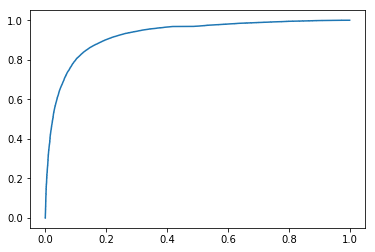

0.925788796282


In [161]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
plt.plot(fpr, tpr)
plt.show()
print roc_auc_score(y_test, y_score[:, 1])